In [2]:
from tensorflow import keras
import keras.layers as layers
from keras.utils import to_categorical
from keras.models import Sequential,Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input,LeakyReLU,Conv2D, MaxPooling2D
from keras.datasets import mnist
from keras.optimizers import SGD
from keras.metrics import categorical_crossentropy, binary_crossentropy
import tensorflow as tf
import visualkeras
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from itertools import chain
import ast

In [30]:
def m2():
  model = Sequential()
     # Flatten layer 
  #model.add(Flatten())
  
  # The first fully connected layer 
  model.add(Dense(120, activation = 'relu', input_shape =(400,)))
  
  # The output layer  
  model.add(Dense(1, activation = 'sigmoid'))

  opt = SGD(learning_rate=0.02)
  model.compile(loss = binary_crossentropy,
                optimizer = opt, 
                metrics = ['accuracy']) 
  
  return model



In [31]:
m2_instance = m2()

In [4]:
training_data_m2 = pd.read_csv('training_data_m2.csv')
training_data_m2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   img last conv layer       1427 non-null   object
 1   argument before fc layer  1427 non-null   object
 2   m1 pred                   1427 non-null   int64 
 3   label                     1427 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 44.7+ KB


In [5]:
argument_float = []
for string_data in training_data_m2['argument before fc layer']:
    string_data = string_data.replace("[", "").replace("]", "").replace("\r\n", "").strip()
    values = string_data.split()
    float_values = [float(value) for value in values]
    argument_float.append(float_values)

training_data_m2['argument'] = argument_float
training_data_m2 = training_data_m2.drop(['argument before fc layer', 'img last conv layer', 'm1 pred'], axis = 1)
    


In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(training_data_m2['argument'], 
                                                    training_data_m2['label'],
                                                    train_size=0.8
                                                    )


In [26]:
#X_train = np.array(X_train)
#Y_train = np.array(Y_train)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(batch_size)



ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [7]:
batch_size = 128
epochs = 1

def data_generator(data, labels):
    for inn, label in zip(data, labels):
        yield np.array(inn), [label]

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_train, Y_train),
    output_signature=(
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(1,), dtype=tf.float32)
    )
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_test, Y_test),
    output_signature=(
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(1,), dtype=tf.float32)
    )
)

In [17]:
def find_samples_with_incorrect_features(dataset):
    incorrect_samples = []
    for sample in dataset:
        features, labels = sample
        if features.shape[0] != 400 or labels.shape[0] != 1:
            incorrect_samples.append(sample)
    return incorrect_samples

print("Train Dataset:")
incorrect_train_samples = find_samples_with_incorrect_features(train_dataset)
print("Number of incorrect samples in train dataset:", len(incorrect_train_samples))

print("\nTest Dataset:")
incorrect_test_samples = find_samples_with_incorrect_features(test_dataset)
print("Number of incorrect samples in test dataset:", len(incorrect_test_samples))
    

Train Dataset:
Number of incorrect samples in train dataset: 0

Test Dataset:
Number of incorrect samples in test dataset: 0


In [33]:

history = m2_instance.fit(train_dataset, epochs = epochs, batch_size = batch_size, 
                    validation_data = (test_dataset))


ValueError: in user code:

    File "c:\Users\oskar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\oskar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\oskar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\oskar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\oskar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\oskar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_3' (type Sequential).
    
    Input 0 of layer "dense_6" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential_3' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=True
      • mask=None


In [52]:
X_test_array = X_test.to_numpy()

# Reshape the flattened data to match the input shape expected by your model
reshaped_X_test = X_test_array.reshape(-1)
#tensor_X_test = tf.convert_to_tensor(reshaped_X_test)



In [248]:

prediction = m2_instance.predict(test_dataset)
dataset_length = 0
for _ in test_dataset:
    dataset_length += 1
print("Dataset length:", dataset_length)
print("Pred Length: ", len(prediction)) #????


286/286 [==============================] - 0s 1ms/step
Dataset length: 286
Pred Length:  114400


In [249]:
predicted_labels = (prediction > 0.5).astype(int)
count = 0
pred_lab = []
for x,y in zip(predicted_labels,Y_test):
    pred_lab.append(x)
    if x == y:
        count +=1
print(count/len(Y_test))

len(pred_lab)

0.951048951048951


286

In [217]:
len(prediction)

114400

Text(70.72222222222221, 0.5, 'True classes')

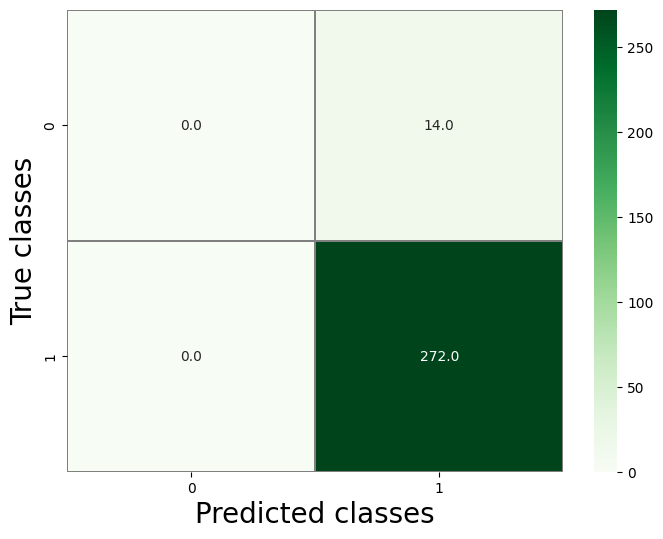

In [250]:
con_mat = confusion_matrix(Y_test, pred_lab)

plt.figure(figsize = (8,6))
sns.heatmap(con_mat, linewidths = 0.1, cmap = 'Greens', linecolor = 'gray', 
            fmt = '.1f', annot = True)
plt.xlabel('Predicted classes', fontsize = 20)
plt.ylabel('True classes', fontsize = 20)